# Gas Phase UED Processing Code
Written by LFH in Oct 2023. 
Adapted from code provided by Yusong Liu and Caidan Moore

### To Do
* Trouble shoot 
* Create simulated difference diffraction package
* Explore code for time evolving diffraction simulations

## Import Necessary Functions

In [3]:
# Standard Packages
import numpy as np
from tifffile import tifffile as tf
import glob
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy.ma as ma
import scipy.signal as ss
import scipy.interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import medfilt2d
import skimage.transform as skt
import math
import scipy
import matplotlib.pyplot as plt
import matplotlib
%matplotlib widget

#Image stuff
import matplotlib.patches as patches
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops_table
from skimage import util
import cv2

#ff stuff
import os

# Running in Parallel
from multiprocessing.dummy import Pool
import multiprocessing

## Define Functions

### Processing Files

In [4]:
def get_data(file_path, shape = False, file_names = False):
    """
    Generates an array of images of TIFF files.
    
    Arguments:
    
    file_path (string) = Path containing the UED TIFF files. Path can be for a singular image or for a folder containing
                        many files. See examples below for example using //*// format style.
    shape (bool, optional) = Boolean expression. If set to True, function returns the shape of the image data array.
    file_names (bool, optional) = Boolean Expression. If set to true, function returns the list of file names.
    
    Returns: data_array, shape (if True), file_names (if True)
    
    numpy array or tuple: 
            If shape = False, file_names = False: Returns numpy array containing data from tiff files as a n x shape x shape (shape refers to the
                                dimensions of the TIFF file, typically 1024 x 1024).
            If shape = True: returns tuple. First element is a numpy array containing data from tiff files as a n x shape x shape
                                (shape refers to the dimensions of the TIFF file, typically 1024 x 1024). Second element is the dimensions
                                of the data array as a tuple.
            If file_names = True: returns tuple containing data array and list with file names.
            
    
    Examples:
    
    file_path = "Desktop/Folder/Data_Analysis/20034291//*//*//ANDOR1_*.tif"
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]]
    
    >>>fileReading(file_path)
        [[data1], ..., [dataN]], (220, 1024, 1024)
    
    Notes:
        - All images must be of same dimension. If images of different shapes needed, either group them by shape and run this function for
            each file shape or create it manually by reading files into a numpy array with dtype = object. Be careful as this can lead to 
            later problems
        - Review "*" notation to read in all files of a singular type. Expedites the process.
    
    """
    files = glob.glob(file_path) #read in file name
    if not files:
        FileNotFoundError(f"file_path input does not contain any TIFF files: {file_path}")
    data_array = tf.imread(files) # construct array containing files
    if shape and file_names:
        return data_array, data_array.shape, files
    elif shape:
        return data_array, data_array.shape
    elif file_names:
        return data_array, files
    else:
        return data_array
    
def stagePosition(file_names, idx_start, idx_end, unique_positions = False ):
    """
    Finds the stage position in the string for every file name in the list of all TIFF files. Requires the user to find the
    index of the first digit and last digit of a single file and assumes all files are formatted identically. It uses these indices
    to retrieve the digits from the file names and stores them in a list. All files must have the exact same number of characters before
    the stage position in the name of the file. If this is an issue, group the file names by preceding characters and run this function
    on each list of files.
    
    If unique_positions = False, it returns the stage positions as a numpy array. If unique_positions = True, it returns a tuple
                        containing an array of the stage positions, an array of the unique stage positions, and an array containing
                        the indices of the unique stage positions in the original array.
    Arguments: 
    
    file_names (list containing strings): List of file names
    idxStart (int): the index of the first digit of the stage position in the file name
    idxEnd (int): the index of the last digit of the stage position in the file name
    unique_positions
    
    Returns: stage_pos, uniq_stage (optional), uniq_stage_idx (optional)
    
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    uniq_stage (array): Optional. A numpy array containing the unique stage positions listed in ascending order.
    uniq_stage_idx (array): Optional. A numpy array containing the indices of the unique stage positions in the original input array.
    
    Examples:
    
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    >>> stagePosition(file_names, 9, 11)
        [10. 20. 40. 30. 40.]
    
    >>> stagePosition(file_names, 9, 11, unique_positions = True)
        (array([10., 20., 40., 30., 40.]), array([10., 20., 30., 40.]), array([0, 1, 3, 2]))

    """
    try:
        try:
            stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            stage_pos = np.array(stage_pos)
            if unique_positions == True:
                uniq_stage, uniq_stage_idx = np.unique(stage_pos, return_index = True)
                return stage_pos, uniq_stage, uniq_stage_idx
            else:
                return stage_pos
            return stagePos
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names.""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")

def get_counts(data_array, plot = False):
    """
    Generates the counts from the given data by summing over the array elements. Returns 2d array of the same dimension as the
    input images.
    
    Arguments:
    
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    plot (bool, optional): If set to true, generates a graph of the counts data.
    
    Returns:
    counts (numpy.ndarray): One dimensional numpy array containing the data after summing over each array element.
    
    Example:
    
    data = np.array([[[1, 2, 3], [4, 5, 6]], [[7, 8, 9], [10, 11, 12]]])
    >>>countData(data)
        array([21, 51])
    """
    counts = np.sum(data_array, axis = (1,2))
    if len(data_array) == 0:
        raise ValueError("Input data_array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data_array is not 3 dimensional.")
    if plot == True:
        plt.plot(np.arange(len(data_array[:, 0, 0])), counts)
        plt.show()
    return counts

def get_image_details(file_names):
    """
    Returns the data loaded from the tif files with a floor subtracted based on the median of the corner. Also returns arrays with the stage positions, the
    file order number, and the number of counts per image.
    
    Arguments: 
    data_array (numpy.ndarray): Numpy data array containing the diffraction images.
    file_names = ['image001_10.tif', 'image002_20.tif', 'image004_40.tif', 'image003_30.tif', 'image004_40.tif']
    
    Returns:
    data_array (ndarray): Array of N x 1024 x 1024 where N is the length of tile file_names list. Generated by using tifffile as tf.
    stage_pos (array): Default. A numpy array containing the stage positions of the file. The index of each stage position corresponds to
                            the index of the file name in file_names.
    file_order (array): Returns the image number located in the file name. Reflects the order with which the images are taken. 
    counts(ndarray): One dimensional numpy array of length N containing the data after summing over each array element.

    """
    data_array = tf.imread(file_names) # construct array containing files
    
    try:
        stage_pos = []
        file_order = []
        try:
            #stage_pos = [np.float64(file_name[idx_start:idx_end]) for file_name in file_names]
            #stage_pos = np.array(stage_pos)
            for file in file_names:
                string = list(map(str, file.split("/")))
                string = list(map(str, string[-1].split("_")))
                file_order.append(int(string[2]))
                stage_pos.append(float(string[3]))
        except ValueError:
            raise ValueError("""Failed to convert a file name to a float. Make sure that index positions are correct for all files in file_names. Also check separators""")
    except IndexError:
        raise ValueError("Invalid index values. Make sure the index values are within the range of the file name strings.")
    
    stage_pos = np.array(stage_pos)
    file_order = np.array(file_order)
    
    counts = get_counts(data_array)
    
    return data_array, stage_pos, file_order, counts 

def clean_and_filter(data_array):
    clean_data_array = []
    for data in data_array:
        floor = np.median(data[-100:, -100:])
        new_data = data-floor
        filt_data = medfilt2d(new_data)
        clean_data_array.append(np.array(new_data))
    
    return clean_data_array




### Cleaning Functions

In [5]:
def cleanMean(data_array, std = 4, return_clean_data = True):
    """
    Takes in a data array and calculate the mean and standard deviation at each index across all images. Then applies a filter
    to the data that masks all values (replaces outliers with nan's) outside a given number of standard deviations. After, the 
    mean is taken, returning a 2 dimensional array with the mean data of non-outlier entries across all images.
    
    If return_clean_data is set to True, the cleaned data is returned as a 3d array without having the mean taken.
    
    Arguments:
    
    data_array (numpy.ndarray): Data array containing diffraction image data.
    std (int or float): Number of standard deviations from the mean allowed. Values outside this number of standard deviations
                        are masked as nan's. Set to 3 by default.
                        
    Returns:
    
    clean_mean_data (numpy.ndarray): Default. Returns a 2 dimensional array containing the mean values of the cleaned data.
    clean_data (numpy.ndarray): Other option. Returns the raw 3 dimensional array containing the cleaned data.
    
    Examples:
    
    example_array = np.array([[[8.,2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]], [[1., 2], [1,2]]])
    
    >>> cleanMean(example_array, std=1)
        np.array([[1.,2],[1.,2]])
    
    >>> cleanMean(example_array, std=1, return_clean_data = True)
        np.array([[[np.nan, 2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]], [[1.,2],[1,2]]])
    """
    if len(data_array) == 0:
        raise ValueError("Input data array is empty.")
    if data_array.ndim != 3:
        raise ValueError("Input data array is not 3 dimensional.")
    if std <= 0:
        raise ValueError("Number of standard deviations (std) must be non-negative.")
    if not isinstance(return_clean_data, bool):
        raise TypeError("return_clean_data must be a boolean value.")
   
    mean = np.mean(data_array, axis = 0)
    stDev = np.std(data_array, axis = 0)
    upper_threshold = mean + std*stDev
    #lower_threshold = mean - std*stDev
    clean_data = ma.masked_greater_equal(data_array, upper_threshold)
    #clean_data = ma.masked_outside(data_array, lower_threshold, upper_threshold)
    pct_rmv = []
    for i in range(len(clean_data)):
        no_rmv = sum(sum(clean_data[i].mask))
        pct_rmv.append(no_rmv/(1024*1024) * 100)

    pct_rmv = np.array(pct_rmv)
    plt.figure()
    plt.plot(pct_rmv)
    plt.title("Percent Pixels Removed")
    plt.xlabel("Image Number")
    plt.ylabel("Percent")
    plt.show()
    if return_clean_data == True:
        return clean_data
    else:
        clean_mean_data = np.mean(clean_data, axis = (0))
        return clean_mean_data
    
def medianFilter(data_array, center_top_left_corner, center_border_length, med_filter_range = 3):
    """
    Takes in a data array and applies scipy.signal's median filter. Then replaces the boundary and center values with the
    original values from the input array as to not lose precision in these parts. 
    
    Arguments:
    
    data_array (np.array): 2d Numpy array containing diffraction image data.
    center_top_left_corner (tuple): Tuple containing the row index (integer) and column index (integer) of the top left corner
                                    (lowest_index_row, lowest_index_column)
    center_border_length (int): Length of one side of the square. Must be an integer.
    med_filter_range (int): Must be odd. Initially set to 3. Shape of the square array for median filtering. Using an odd values makes it so that the 
                            median filter is centered around the individual point.
    
    Returns:
    
    med_filt_data (2d-array): Array containing the median filtered data.
            
    """
    if not isinstance(data_array, np.ndarray):
        raise ValueError("Input data_array must be a 2D numpy array.")
    if not isinstance(center_top_left_corner, tuple) or len(center_top_left_corner) != 2:
        raise ValueError("Center top left corner must be a tuple of length 2 that contains two integers.")
    if not isinstance(center_border_length, int):
        raise ValueError("center_border_length must be an integer.")
    #if not isinstance(center_top_left_corner[0] + center_border_length < data_array[0,-1]  
    if not (0 <= center_top_left_corner[0] < data_array.shape[0] and
        0 <= center_top_left_corner[1] < data_array.shape[1] and
        center_top_left_corner[0] + center_border_length <= data_array.shape[0] and
        center_top_left_corner[1] + center_border_length <= data_array.shape[1]):
        raise ValueError("""center_top_left_corner is out of bounds or adding center_border_length goes beyond the array.
                     Check that the tuple values are positive integers within the bounds of the data array and that 
                     adding the border length does not result in a value beyond the size of the array.""")
    if not isinstance(med_filter_range, int) and med_filter_range % 2 == 1:
        raise ValueError("med_filter_range must be an odd integer.")

    med_filt_data = ss.medfilt2d(data_array, med_filter_range)
    med_filt_data[0:med_filter_range//2,:] = data_array[0:med_filter_range//2,:]
    med_filt_data[-(med_filter_range//2):0,:] = data_array[-(med_filter_range//2):0,:]
    med_filt_data[:,0:med_filter_range//2] = data_array[:,0:med_filter_range//2]
    med_filt_data[:,-(med_filter_range//2):] = data_array[:,-(med_filter_range//2):]
    row_s, col_s = center_top_left_corner
    row_e, col_e = row_s+center_border_length, col_s+center_border_length
    med_filt_data[row_s:row_e,col_s:col_e] = data_array[row_s:row_e,col_s:col_e]
    return med_filt_data

def backgroundNoise(data_array, bkg_range = 20, remove_noise = False):
    """
    Takes in a 2d data array (using the mean array is recommended) and calculatees the means of the corners. Linearly interpolates values across 2d array to 
    generate of background noise values using pandas.DataFrame.interpolate. Returns a two dimensional numpy array with the linearly interpolated
    background noise.

    Arguments:

    data_array (2d np.ndarray): Data array used to generate the corner values of the background noise.
    bkg_range (int): Side length of square in each corner used for generating mean value. Initially set to 20.
    remove_noise (Bool): If set to true, generated background values are subtracted from the initial input array. Returns cleaned data.
    
    Returns:
    
    bkg_data (2d np.ndarray): Data array containing the linearly interpolated background noise for the image. If remove_noise = True,
                                returned data has background noise removed from original input.
    """
    if not isinstance(data_array, np.ndarray):
        raise ValueError("Input data_array must be a numpy array.")
    if not isinstance(bkg_range, int) and bkg_range > 0:
        raise ValueError("bkg_range must be an integer > 0.")
    if not isinstance(remove_noise, bool):
        raise ValueError("remove_noise must be a boolean.")
    if not (2 * bkg_range < len(data_array[0,:]) and
            2 * bkg_range < len(data_array[:,0])):
        raise ValueError("2 * bkg-range must be less than both the number of rows and the number of columns.")

    empty_array = np.empty(np.shape(data_array))
    empty_array = (ma.masked_array(empty_array, mask = True))
    empty_array[0,0] = np.mean(data_array[0:20,0:20])
    empty_array[-1,0] = np.mean(data_array[-20:,0:20])
    empty_array[0,-1] = np.mean(data_array[0:20,-20:])
    empty_array[-1,-1] = np.mean(data_array[-20:,-20:])
    empty_array = pd.DataFrame(empty_array).interpolate(axis = 0)
    empty_array = pd.DataFrame(empty_array).interpolate(axis = 1)
    bkg_data = pd.DataFrame.to_numpy(empty_array)
    if remove_noise == True:
        return data_array - bkg_data
    else:
        return bkg_data
    


### Masking Functions

In [6]:
def detectorMask(data_array, hole_center, inner_radius, outer_radius, plot_image = True):
    """
    Takes in a 2d data array and applies a circular (donut shaped) detector mask to it, replacing the masked values with np.nan's.
    Returns the masked, 2d data array.

    Arguments:
    
    data_array (2d np.ndarray): 2d data array to be masked.
    hole_center (tuple): Tuple containing the x and y coordinates of the center of the image, each one of which an int.
    inner_radius (float): Inner radius. Values within the radius of this drawn from the center are masked.
    outer_radius (float): Outer radius of the donut. Values outside the radius of this drawn from the center are masked.
    plot_image (bool, optional): If True, plots the masked image. Default is False.

    Returns:
    ring_data (2d np.ndarray): Data array with the circular detector mask applied.
    """
    if not isinstance(hole_center, tuple) or len(hole_center) != 2:
        raise ValueError("hole_center must be a tuple of length 2 containing the x and y coordinates of the hole center.")
    if not (isinstance(inner_radius, (int, float)) and inner_radius > 0):
        raise ValueError("inner_radius must be a positive float or integer.")
    if not (isinstance(outer_radius, (int, float)) and outer_radius > 0):
        raise ValueError("outer_radius must be a positive float or integer.")
    if inner_radius >= outer_radius:
        raise ValueError("inner_radius must be smaller than outer_radius.")


    hole_cx, hole_cy = hole_center
    x_idx, y_idx = np.meshgrid(np.arange(data_array.shape[2]), np.arange(data_array.shape[1]))
    dist = np.sqrt(((x_idx - hole_cx)**2 + (y_idx-hole_cy)**2))
    mask = np.logical_and(dist<=outer_radius, dist>= inner_radius)
    ring_data = []
    for i in range(len(data_array)):
        data = np.where(mask, data_array[i], np.nan)
        ring_data.append(data)
        
    ring_data = np.array(ring_data)
    if plot_image == True:
        img3 = plt.imshow(ring_data[0])
        plt.colorbar(img3)
    return(ring_data)

    
def mask_hole(I,fit_bor,hole_bor,value_bor,show='yes'):
       
    [X_fit,Y_fit]=np.where((I[fit_bor[0][0]:fit_bor[0][1],fit_bor[1][0]:fit_bor[1][1]]<1.1*value_bor) &
                           (I[fit_bor[0][0]:fit_bor[0][1],fit_bor[1][0]:fit_bor[1][1]]>0.9*value_bor))
    if show=='yes':
        plt.scatter(Y_fit+fit_bor[1][0],X_fit+fit_bor[0][0])
    center_hole,r_hole=fit_circle([X_fit+fit_bor[0][0],Y_fit+fit_bor[1][0]])
    
    mask=np.ones((hole_bor[0][1]-hole_bor[0][0],hole_bor[1][1]-hole_bor[1][0])).astype(float)
    for xi in range(len(mask)):
        for yi in range(len(mask[xi])):
            if (xi-center_hole[0]+hole_bor[0][0])**2 + (yi-center_hole[1]+hole_bor[1][0])**2 <= (r_hole+3)**2:
                mask[xi,yi]=np.nan
    I[hole_bor[0][0]:hole_bor[0][1],hole_bor[1][0]:hole_bor[1][1]]=I[hole_bor[0][0]:hole_bor[0][1],hole_bor[1][0]:hole_bor[1][1]]*mask
    
    return mask,center_hole,r_hole

### Center Finding

In [7]:
def find_beam_center(I,center=[500,500],r=200,printr2='no',recursiontime=0):

    recursiontime+=1
    #up down right left,r away pixles average
    fit_value=np.average([I[center[0]+r][center[1]],I[center[0]-r][center[1]],I[center[0]][center[1]+r],I[center[0]][center[1]-r]])
    
    [X_f,Y_f]=np.where((I>0.999*fit_value) & (I<1.001*fit_value))
    
    #plt.figure()
    #plt.scatter(Y_f,X_f)
    #plt.imshow(I)
    a=len(X_f)
    i=0
    #delete fit_points which are too far away from fit_circle, range from 0.5r to 1.5r
    while(i<a):
        ri2=(X_f[i]-center[0])**2+(Y_f[i]-center[1])**2
        if (ri2>(1.5*r)**2) or (ri2<(0.5*r)**2):
            X_f=np.delete(X_f,i)
            Y_f=np.delete(Y_f,i)
            i-=1
            a-=1
        i+=1
    center_new,r_new=fit_circle([X_f,Y_f],printr2)
    
    if r_new==0:
        return [0,0]
    elif ((center[0]-center_new[0])**2 +(center[1]-center_new[1])**2) <=1 :
        #new center pretty close to old center
        return center_new
    elif recursiontime>=10:
        return [0,0]
    else:
        #else: iterate
        return find_beam_center(I,center_new,r_new,recursiontime=recursiontime)
    
    
    
def fit_circle(fit_points,printr2='yes'):
    
    #circle function: ax+by+c=-(x^2+y^2)
    
    A=np.empty((len(fit_points[0]),3))
    B=np.empty(len(fit_points[0]))
    
    for i in range(len(fit_points[0])):
        B[i]=-(fit_points[0][i]**2+fit_points[1][i]**2)
        A[i][0]=fit_points[0][i]
        A[i][1]=fit_points[1][i]
        A[i][2]=1
    
    #A[i]=[xi,yi,1], B[i]=-(xi^2+yi^2), par=[a,b,c]
    #namely A*par=B, least square method
    if np.linalg.det(np.dot(A.T,A)) == 0:
        return [],0
    par=np.dot(np.dot(np.linalg.inv(np.dot(A.T,A)),A.T),B)
    
    #correlation coeff, if not very close to 1(less than 3 nines), be careful
    if printr2=='yes':
        y_ave=np.mean(B)
        r2=np.sum((np.dot(A,par)-y_ave)**2)/np.sum((B-y_ave)**2)
        print(r2)
    
    center_new=[round(-par[0]/2),round(-par[1]/2)]
    r_new=round(np.sqrt(par[0]**2+par[1]**2-4*par[2])/2)
    
    return center_new,r_new
    

### Radial Averaging

In [8]:
def azimuthal_integration(data_array, center, correction_factor=3):
    """
    Performs azimuthal integration over the data set, removing radial outliers as it performs the integration. 
    Function coverts to polar coordinates, the calculates the mean and std at every radial distance (distances are
    previously round to the nearest positive integer and grouped by integer). Returns the azimuthal integration data
    and the azimuthal error.
    
    Arguments:
    
    data_array (np.ndarray): Two dimensional numpy array containing the diffraction image. 
    center (tuple): Tuple containing the integer coordinates of the image center.
    correction_factor (int, optional): Number of standard deviations set as threshold. Preset to 3.
    
    Return: (azi_dat, azi_err)
    
    azi_dat (np.ndarray): Array containing the integrated data.
    azi_err (np.ndarray): Array containing the error of the integrated data.
    
    Example:
    
    sample_array = np.random.rand(100,100)
    center = (40,40)
    
    >>> azimuthal_integration(sample_array, center, correction_factor = 2)
        azi_dat, azi_err
    """

    
    x_mat, y_mat = np.meshgrid(np.arange(0,data_array.shape[1],1)-center[1],np.arange(0,data_array.shape[0],1)-center[0])
    #rmat, _ = cart2pol(xmat, ymat)
    
    r_mat = np.sqrt(x_mat**2 + y_mat**2)
    #phi = np.arctan2(y_mat,x_mat)
                               
    rmat = np.around(r_mat)
    data_array = data_array.astype(float)
    data_array[data_array==0] = np.nan
    x_length = int(np.amax([np.amax(abs(x_mat)),np.amax(abs(y_mat))]))
    azi_dat = np.zeros(x_length)
    azi_err = np.copy(azi_dat)
    for i in range(x_length):
        roi = data_array[r_mat==int(i+1)].astype(float)
        #print(roi)
        if len(roi)==0:
            break
        std = np.nanstd(roi)
        idxx = np.logical_and(roi <= np.nanmean(roi)+correction_factor*std,roi >=np.nanmean(roi)-correction_factor*std)
        idxx = util.invert(idxx)
        roi[idxx] = np.nan
        
        azi_dat[i] = np.nanmean(roi)
        azi_err[i] = np.nanstd(roi)/np.sqrt(abs(np.nansum(roi)))
    return azi_dat, azi_err

def azimuthal_avg_correct(args):
    """Returns the azimuthal average of a diffraction image based on the radial distance of the x, y positions in the image."""
    data, x, y = args
    r_max=len(x)
    I=np.empty(r_max)
    for ri in range(r_max):
        I_r=data[x[ri],y[ri]]
        ave=np.nanmean(I_r)
        sigma=np.nanstd(I_r)
        I_r[np.abs(I_r-ave)>=3*sigma]=np.nan
        I[ri]=np.nanmean(I_r)
    return I


def multiprocess_azimuthal_avg(data,x,y):
    """Runs the azimuthal average function in parallel for large data sets."""
    p = Pool(3)
    I=p.map(azimuthal_avg_correct, [(data_i,x,y) for data_i in data]) 
    return np.array(I)

## Reading in Data and Visualizing

### Defining path -- Uses * to make more accessible for reading in multiple scan files

In [9]:
dataPath = '/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/gued_demo_data/20201027/Run'
runPath = "/*/*/*/ANDOR1_*.tif"

bkg_path = '/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/gued_demo_data/20201027/Background/20201027_1742/*/*/ANDOR1_*.tif'


newPath = dataPath + runPath
print(newPath)
print(bkg_path)

files = glob.glob(newPath) 
bkg_files = glob.glob(bkg_path)
print(len(files))
print(len(bkg_files))

/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/gued_demo_data/20201027/Run/*/*/*/ANDOR1_*.tif
/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/gued_demo_data/20201027/Background/20201027_1742/*/*/ANDOR1_*.tif
5790
60


### Plotting Example Image

Load a image to check the signal level: /sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/gued_demo_data/20201027/Run/20201027_1944/scan001/images-ANDOR1/ANDOR1_Delay_1704_156.30496850_0001.tif
Total number of images in the chosen directory is 5790
Load background signal


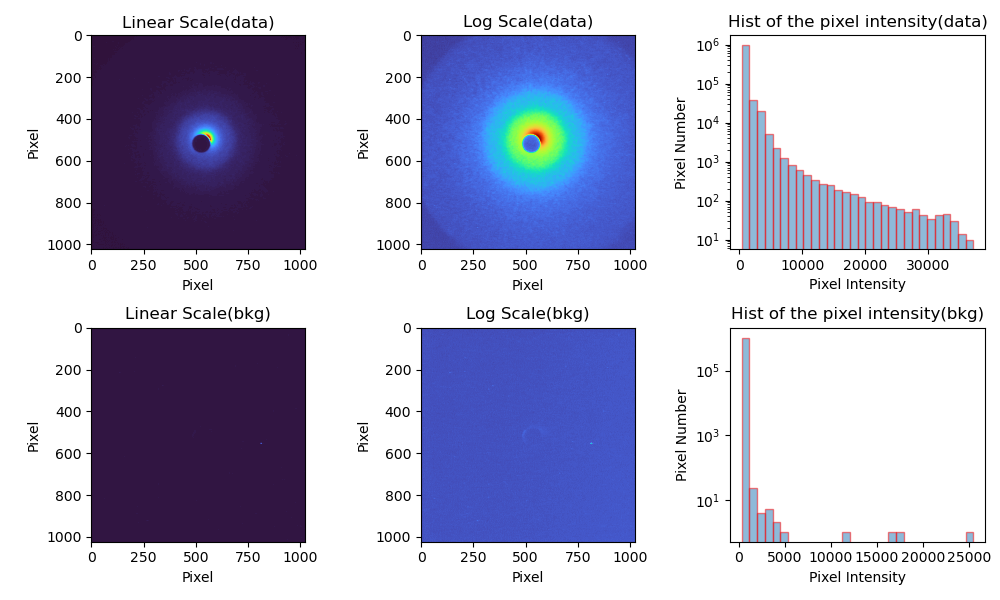

In [10]:
test=tf.imread(files[0]);
bkg_sign='Yes'
print('Load a image to check the signal level: '+files[0]);
print('Total number of images in the chosen directory is ' + str(len(files)));

# Load or not load the bkg signal
if bkg_sign == 'Yes':
    print('Load background signal');
    data_bkg, _, _, _ = get_image_details(bkg_files) # Load bkg images
    test_bkg = tf.imread(bkg_files[0])
    bkg_dlys_ave = np.nanmean(data_bkg,axis=0) # averaging all the images to optain one image

# Plot a testing figure and check the intensity
plt.figure(figsize=(10,6))

if bkg_sign == 'Yes': # Plot both the data and the background images
    plt.subplot(2,3,1);
    plt.imshow(test,cmap='turbo');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(2,3,2);
    plt.imshow(np.log(test),cmap='turbo');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(2,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
    
    plt.subplot(2,3,4);
    plt.imshow(test_bkg,cmap='turbo');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(bkg)')
    
    plt.subplot(2,3,5);
    plt.imshow(np.log(test_bkg),cmap='turbo');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(bkg)')
    
    plt.subplot(2,3,6);
    plt.hist(test_bkg.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(bkg)');
    plt.yscale('log')
    
else:
    plt.subplot(1,3,1);
    plt.imshow(test,cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Linear Scale(data)')
    
    plt.subplot(1,3,2);
    plt.imshow(np.log(test),cmap='jet');
    plt.xlabel('Pixel');
    plt.ylabel('Pixel');
    plt.title('Log Scale(data)')
    
    plt.subplot(1,3,3);
    plt.hist(test.reshape(-1),bins=30,edgecolor="r",histtype="bar",alpha=0.5)
    plt.xlabel('Pixel Intensity');
    plt.ylabel('Pixel Number');
    plt.title('Hist of the pixel intensity(data)');
    plt.yscale('log')
plt.tight_layout()
plt.show()

### Reading in All Data and Getting Total Counts -- Lauren's Version

In [11]:
%%time

highvalue = 50000 # The highest value of pixel intensity from the histogram plot
posi_0    = 108.62 # The reference T0
print('Load diffraction signal');
test_data, stage_positions, file_numbers, counts = get_image_details(files)
counts_mean = np.mean(counts)        # Mean values of Total Counts of all images
counts_std  = np.std(counts)         # the STD of all the tc for all the iamges
uni_stage = np.unique(stage_positions)# Pump-probe stage position

print('Image number read: ', len(counts))
print('Stage positions: ', len(uni_stage))


Load diffraction signal
Image number read:  5790
Stage positions:  39
CPU times: user 13.8 s, sys: 13.7 s, total: 27.5 s
Wall time: 29.1 s


### Visualizing Data Info

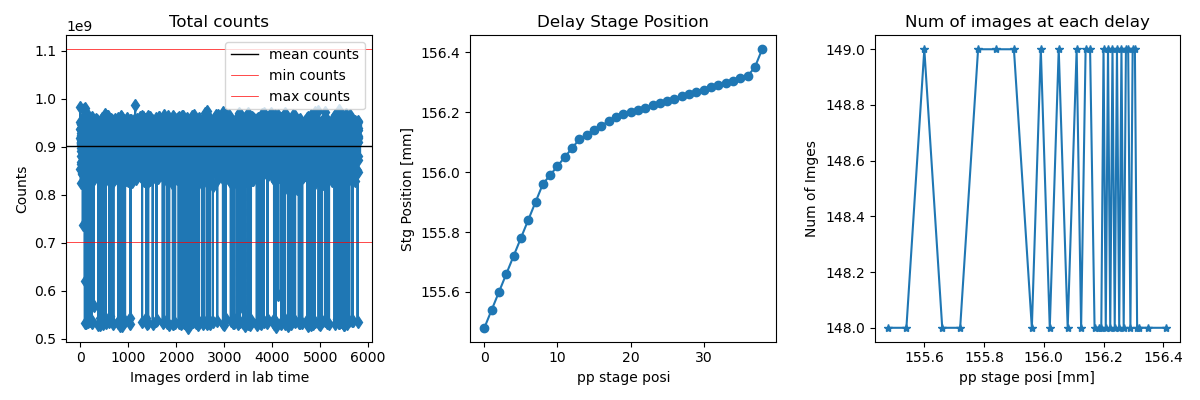

In [12]:
fig = plt.figure(figsize = (12,4)) # Plot counts rate, images number at each posi, and bad images

plt.subplot(1,3,1)
plt.plot(counts,'-d')
plt.axhline(y = counts_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts');

plt.subplot(1,3,2) # Histogram the number of images at each posi
plt.plot(uni_stage,'-o');
plt.xlabel('pp stage posi');
plt.ylabel('Stg Position [mm]');
plt.title('Delay Stage Position');

plt.subplot(1,3,3) # Histogram the number of images at each posi
posi_edges_bins = np.append(uni_stage-0.001,uni_stage[-1])
posi_hist,posi_edges = np.histogram(stage_positions,bins=posi_edges_bins)
plt.plot(uni_stage,posi_hist,'-*')
plt.xlabel('pp stage posi [mm]');
plt.ylabel('Num of Imges');
plt.title('Num of images at each delay');

plt.tight_layout()
plt.show()

## Filtering Out Bad Shots Based on Total Counts

Either remove shots based on the standard deviation of the total counts or manually select which files to remove based on the image number.  
Edited to include a T/F option instead of "if 1 == 1" and defining based on "good" data instead of "bad" data so that indexing can be applied more easily

In [13]:
# Decide to use all data or selected images
remove_std = True 
if remove_std is True:
    # Auto find out the bad images by filtering on the total counts
    tc_good = np.squeeze(np.where(abs(counts-counts_mean)<3*counts_std)) # Find out the indices of the low counts images
    good_data = test_data[tc_good]
    good_stage = stage_positions[tc_good]
    good_counts = counts[tc_good]
else:
    # Manual find out the bad images by checking the tc from last figure
    tc_bad = np.concatenate((np.arange(922,925,1), np.arange(1318,1321,1), np.arange(2112,2261,1)))# Make range around the bad files instead of range of bad files in order to index easier
    tc_good = np.concatenate((np.arange(0, 923, 1), np.arange(926, 1319, 1), np.arange(1322, 2113, 1), np.arange(2261, len(test_data), 1)))
    good_data=test_data[tc_good]
    good_stage = stage_positions[tc_good]
    good_counts = counts[tc_good]

print(len(good_data))

5637


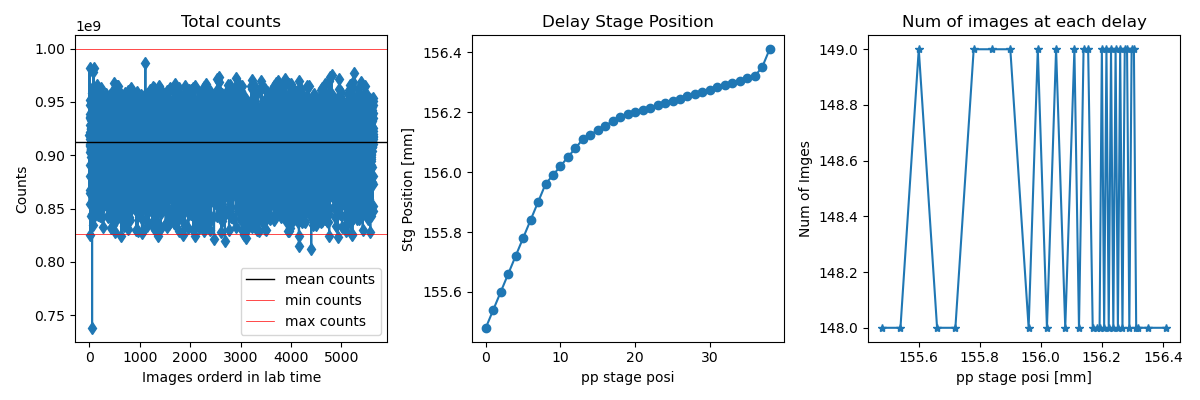

In [14]:
counts_mean = np.mean(good_counts)
counts_std = np.std(good_counts)

fig = plt.figure(figsize = (12,4)) # Plot counts rate, images number at each posi, and bad images

plt.subplot(1,3,1)
plt.plot(good_counts,'-d')
plt.axhline(y = counts_mean, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*counts_std), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts');

plt.subplot(1,3,2) # Histogram the number of images at each posi
plt.plot(uni_stage,'-o');
plt.xlabel('pp stage posi');
plt.ylabel('Stg Position [mm]');
plt.title('Delay Stage Position');

plt.subplot(1,3,3) # Histogram the number of images at each posi
posi_edges_bins = np.append(uni_stage-0.001,uni_stage[-1])
posi_hist,posi_edges = np.histogram(stage_positions,bins=posi_edges_bins)
plt.plot(uni_stage,posi_hist,'-*')
plt.xlabel('pp stage posi [mm]');
plt.ylabel('Num of Imges');
plt.title('Num of images at each delay');

plt.tight_layout()
plt.show()

In [15]:
print(good_data.shape)

(5637, 1024, 1024)


## Averaging Based on Delay Position

In [16]:
%%time
stage_len = len(uni_stage);               #  Number of delays
data_dlys = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images
data_dlys_mk = np.ones((stage_len,1024,1024)); #  Delay dependent averaged pp images with mask

if stage_len>20:
    prt_count = 5
else:
    prt_count = 1  
for i in range(stage_len):
    if i%prt_count == 0:
        print('Averaging data at stage posi # '+ str(i) + ', ' + str(uni_stage[i]) + ' mm') # Obtain a sub array to save the data in one delay
    idx_step     = np.squeeze(np.where(good_stage==uni_stage[i]));
    idx_step     = [i for i in idx_step if i in tc_good]
    data_step    = good_data[idx_step]
    if bkg_sign == 'Yes':
        data_dlys[i] = np.nanmean(data_step,axis=0) - bkg_dlys_ave; # subtracting the background
    else:
        data_dlys[i] = np.nanmean(data_step,axis=0); # no subtracting background
    data_dlys[i][data_dlys[i]<0] = 0; # make negative values to 0 
    


Averaging data at stage posi # 0, 155.480546 mm
Averaging data at stage posi # 5, 155.780336 mm
Averaging data at stage posi # 10, 156.020168 mm
Averaging data at stage posi # 15, 156.140084 mm
Averaging data at stage posi # 20, 156.200042 mm
Averaging data at stage posi # 25, 156.23751575 mm
Averaging data at stage posi # 30, 156.2749895 mm
Averaging data at stage posi # 35, 156.31246325 mm
CPU times: user 12.6 s, sys: 3.93 s, total: 16.5 s
Wall time: 16.6 s


## Removing Errant X-Ray Values

Here, we utilize a masked array to create nan values for each entry outside of the standard deviation threshold. In this way, we eliminate the need for inputting NaN values, as these are stored as a Boolean.

In [17]:
clean_data_orig = clean_and_filter(data_dlys)
clean_data_orig = np.array(clean_data_orig)
counts_clean_orig = get_counts(clean_data_orig)

counts_mean_orig = np.mean(counts_clean_orig)
counts_std_orig = np.std(counts_clean_orig)

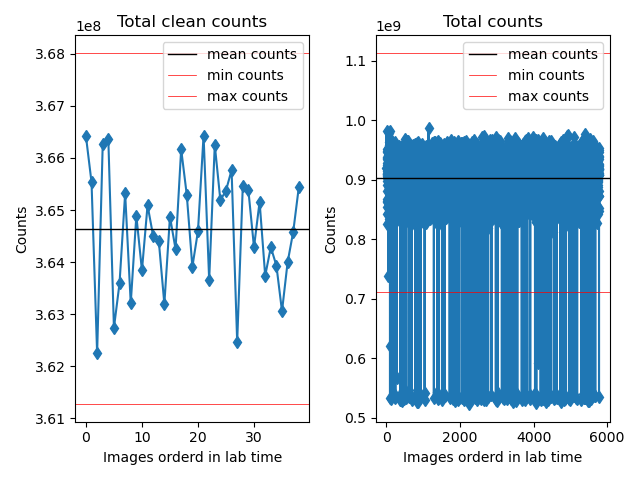

In [18]:
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(counts_clean_orig,'-d')
plt.axhline(y = counts_mean_orig, color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean_orig-(3*counts_std_orig), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean_orig+(3*counts_std_orig), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total clean counts');

plt.subplot(1, 2, 2)
plt.plot(counts,'-d')
plt.axhline(y = np.mean(counts), color = 'k', linestyle = '-',linewidth=1, label="mean counts");
plt.axhline(y = counts_mean-(3*np.std(counts)), color = 'r', linestyle = '-',linewidth=0.5, label="min counts");
plt.axhline(y = counts_mean+(3*np.std(counts)), color = 'r', linestyle = '-',linewidth=0.5, label="max counts");
plt.xlabel('Images orderd in lab time');
plt.ylabel('Counts');
plt.legend()
plt.title('Total counts')     
plt.tight_layout()
plt.show()

## Masking Beam Block

Kind of confused on how cv2.HoughCircles works... This block only makes the mask. It is applied when centers are found

In [19]:
# (1) Hole mask: Define mask of the hole
data_ave_raw = np.mean(good_data,axis=0); # Mean data of all the images
data_ave     = np.copy(data_ave_raw) #[200:900,200:900]
image_array  = np.log(data_ave)/np.nanmax(np.log(data_ave))
image_array  *=255
im = Image.fromarray(image_array)
im = im.convert('L')
im = np.array(im)

# Mask hole and Finding the diffraction center
hole = np.squeeze(cv2.HoughCircles(im, cv2.HOUGH_GRADIENT_ALT, 1.5, 32, param1=50, param2=0.9, minRadius=30, maxRadius=60))
mask = np.ones((1024,1024)) # Hole mask
y_m,x_m = np.ogrid[:1024,:1024];
mask[((x_m-hole[0])**2 + (y_m-hole[1])**2 <= (hole[2]+5)**2)] = np.nan;# Create a circular mask filled with nans inside the circle
print('The hole center at ' + str(hole[0:2]) + ' with radius ' + str(hole[2:3]));

The hole center at [526.5 519. ] with radius [43.0595]


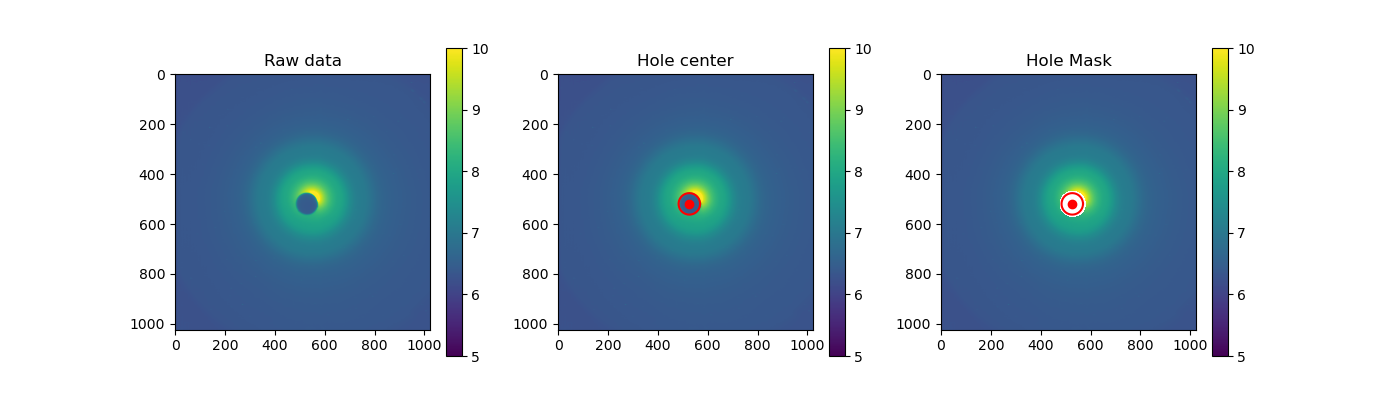

In [20]:
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)*hole[2]+hole[0];
y = np.sin(theta)*hole[2]+hole[1];

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(np.log(data_ave_raw));
plt.colorbar();
plt.clim([5,10]);
plt.title('Raw data')

plt.subplot(1,3,2)
plt.imshow(np.log(data_ave_raw));
plt.colorbar()
plt.plot(x,y,'r',hole[0],hole[1],'or');
plt.clim([5,10]);
plt.title('Hole center');

plt.subplot(1,3,3)
plt.imshow(np.log(data_ave_raw*mask));
plt.colorbar();
plt.plot(x,y,'r',hole[0],hole[1],'or');
plt.clim([5,10]);
plt.title('Hole Mask');

## Finding Diffraction Center

In [24]:
ctrs = np.zeros((stage_len,2));
data_dlys_mask = np.zeros((stage_len, 1024, 1024))
start = time.time()
for i in range(stage_len):
    data_dlys_mask[i] = data_dlys[i]*mask; # apply the mask
    ctrs[i] = find_beam_center(data_dlys[i],printr2='no')
    if i%2 == 0:
        print('Found ctr with ' + str(ctrs[i])+' at stage posi # '+ str(i)+', '+str(uni_stage[i])+' mm')

ctrs[ctrs == 0] = np.nan
ctrs_ave = np.nanmean(ctrs, axis=0)
print(r'Averaged ctr is ' + str(ctrs_ave))
stop = time.time()
print("Way 1 time = ", (stop-start))

Found ctr with [503. 547.] at stage posi # 0, 155.480546 mm
Found ctr with [503. 547.] at stage posi # 2, 155.600462 mm
Found ctr with [502. 547.] at stage posi # 4, 155.720378 mm
Found ctr with [502. 548.] at stage posi # 6, 155.840294 mm
Found ctr with [503. 547.] at stage posi # 8, 155.96021 mm
Found ctr with [502. 547.] at stage posi # 10, 156.020168 mm
Found ctr with [502. 547.] at stage posi # 12, 156.080126 mm
Found ctr with [502. 547.] at stage posi # 14, 156.1250945 mm
Found ctr with [502. 547.] at stage posi # 16, 156.1550735 mm
Found ctr with [502. 547.] at stage posi # 18, 156.1850525 mm
Found ctr with [0. 0.] at stage posi # 20, 156.200042 mm
Found ctr with [503. 547.] at stage posi # 22, 156.2150315 mm
Found ctr with [502. 547.] at stage posi # 24, 156.230021 mm
Found ctr with [502. 547.] at stage posi # 26, 156.2450105 mm
Found ctr with [502. 547.] at stage posi # 28, 156.26 mm
Found ctr with [502. 547.] at stage posi # 30, 156.2749895 mm
Found ctr with [502. 547.] at st

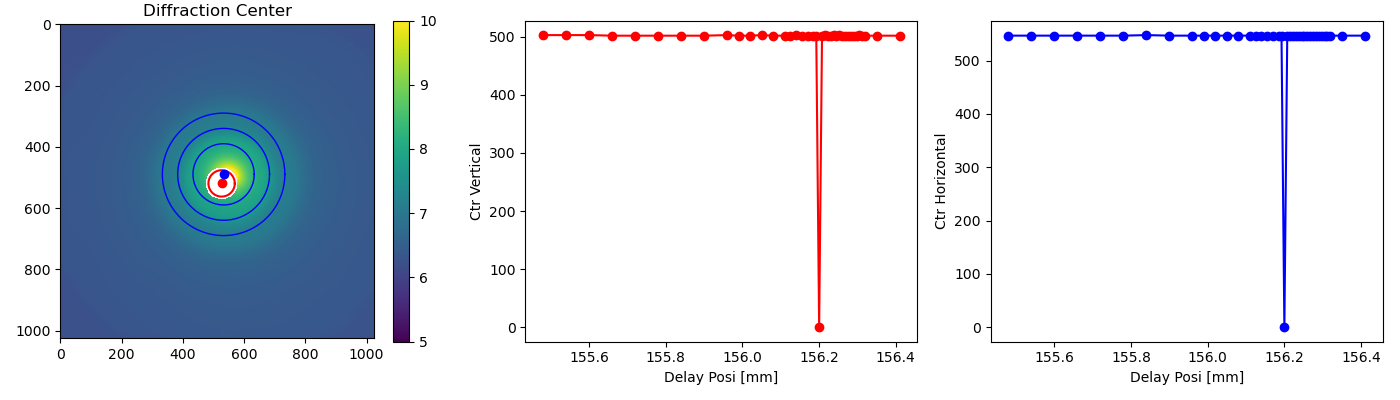

In [27]:
theta = np.linspace(0, 2 * np.pi, 200)
x = np.cos(theta)*hole[2]+hole[0];
y = np.sin(theta)*hole[2]+hole[1];

plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
plt.imshow(np.log(data_ave_raw*mask));
plt.colorbar()
plt.plot(x,y,'r',hole[0],hole[1],'or',np.mean(ctrs,axis=0)[1],np.mean(ctrs,axis=0)[0],'ob');
for i in range(3):
    x = np.cos(theta)*(i+2)*50+np.mean(ctrs,axis=0)[1];
    y = np.sin(theta)*(i+2)*50+np.mean(ctrs,axis=0)[0];
    plt.plot(x,y,linewidth=1,color='b');
plt.clim([5,10]);
plt.title('Diffraction Center')

plt.subplot(1,3,2)
plt.plot(uni_stage,ctrs[:,0],'-or');
plt.xlabel('Delay Posi [mm]');
plt.ylabel('Ctr Vertical');

plt.subplot(1,3,3)
plt.plot(uni_stage,ctrs[:,1],'-ob');
plt.xlabel('Delay Posi [mm]');
plt.ylabel('Ctr Horizontal');

plt.tight_layout()
plt.show();

## Radial Averaging

Runs based on an array of positions based on x and y values. Throws runtime warnings

max Q index is 476


/tmp/ipykernel_3362369/381441402.py:62: RuntimeWarning: Mean of empty slice
  ave=np.nanmean(I_r)
/tmp/ipykernel_3362369/381441402.py:65: RuntimeWarning: Mean of empty slice
  I[ri]=np.nanmean(I_r)
/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.54-py3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Finish azimuthally averaging in  14.635445833206177


/tmp/ipykernel_3362369/606187577.py:19: RuntimeWarning: Mean of empty slice
  I_dlys_mean   = np.nanmean(I_dlys,axis=0);                      # Obtain mean values for all 1D scattering signal


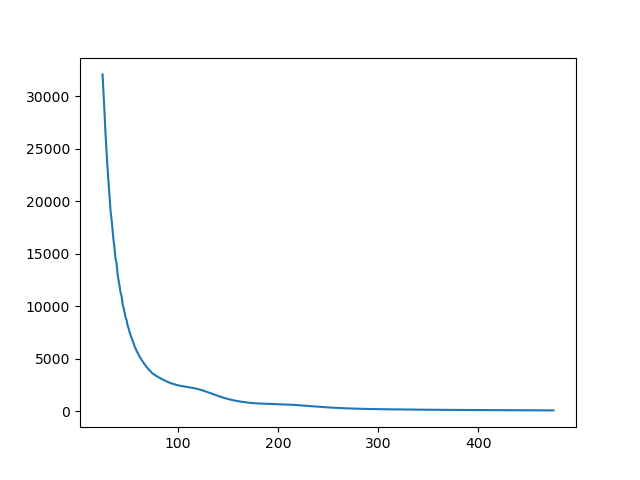

In [25]:
start = time.time()
ctr = ctrs_ave

pointer = np.empty((1024,1024))
for i in range(1024):
    for j in range(1024):
        pointer[i,j]=int(np.sqrt((i-ctr[0])**2+(j-ctr[1])**2))
img_r_max = int(min(ctr[0],ctr[1],1024-ctr[0],1024-ctr[1]))
X=[];Y=[]
for ri in range(img_r_max):
    [X_temp,Y_temp]=np.where(pointer==ri)
    X.append(X_temp)
    Y.append(Y_temp)
print(r'max Q index is ' + str(img_r_max));

# Azimuthally averaging on the data at each delays
I_dlys        = multiprocess_azimuthal_avg(data_dlys_mask, X, Y); # Function of averaging
I_dlys[:,:25] = np.nan;                                         # Set the first 25 pixels as NaN
I_dlys_mean   = np.nanmean(I_dlys,axis=0);                      # Obtain mean values for all 1D scattering signal
TC_0          = np.nansum(I_dlys_mean[80:200]);                 # Obtain the normalization factor
TC_save       = [];                                          # The ratio of the counts at each delay for the normalization
I_dlys_Norm   = np.copy(I_dlys);                                # Normalized 1D scattering signal
for i in range(stage_len):
    TC = np.nansum(I_dlys[i,80:200]);                           # Norm factor
    I_dlys_Norm[i] = I_dlys[i]*TC_0/TC;                      # Normalization 
    TC_save.append(TC_0/TC);                                 # Ratio of the factor
stop = time.time()
print('Finish azimuthally averaging in ', (stop-start));

plt.figure()
plt.plot(I_dlys_Norm[-1])
plt.show()

## Plotting the Time-Dependent Signal

/tmp/ipykernel_3362369/3848718777.py:10: RuntimeWarning: Mean of empty slice
  I_dlys_Norm_Ref = np.nanmean(I_dlys_Norm[-N_ref:],axis=0);         # Reference signal before T0


98


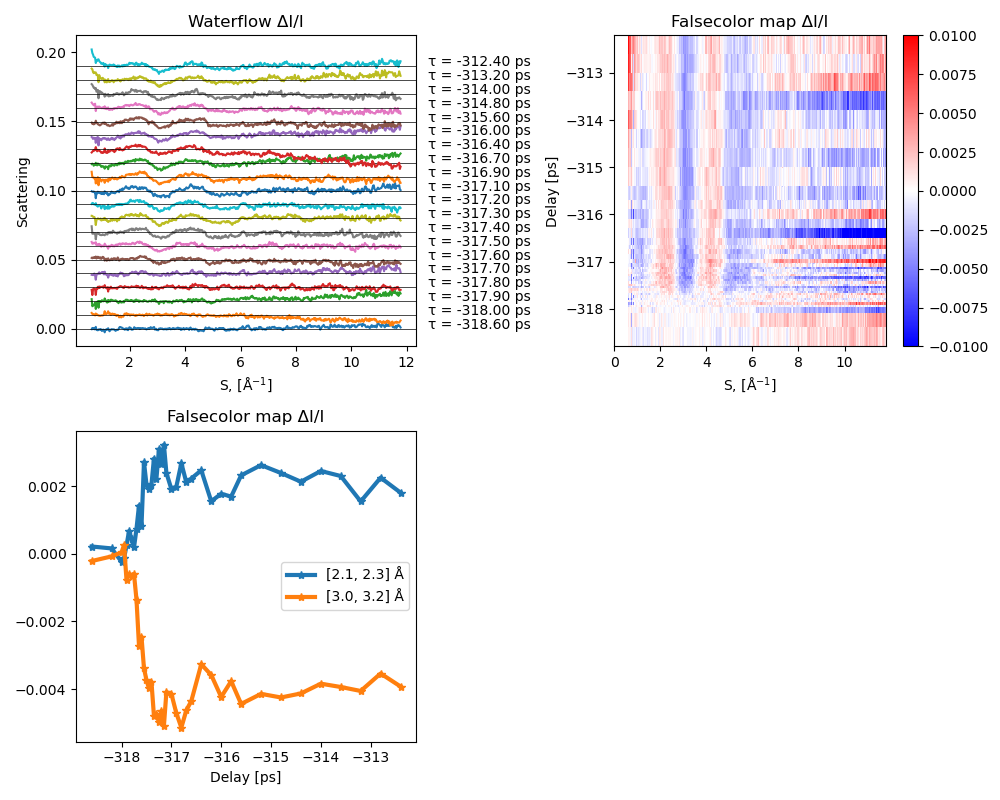

In [26]:
angs = '\u00C5'; # angstrom sign
s_cali = 0.0248 # S calibration in experiment
s = np.arange(0,len(I_dlys[0]))*s_cali # The Q axis
realtime = -(uni_stage-posi_0)/0.15  # Delay axis in ps

if stage_len<5: # Make up the reference signals
    N_ref = 2
else:
    N_ref = 4
I_dlys_Norm_Ref = np.nanmean(I_dlys_Norm[-N_ref:],axis=0);         # Reference signal before T0
dI_I_dlys_Norm = (I_dlys_Norm-I_dlys_Norm_Ref)/I_dlys_Norm_Ref; # Calculate the percentage difference signal

# Plot a figure of the time-depdendent signal of scattering percentage difference.
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
for i in range(stage_len):
    if i%2 == 0:
        plt.plot(s,dI_I_dlys_Norm[stage_len-i-1] + np.nanmax(dI_I_dlys_Norm)*(i)/3);
        plt.text(s[-1]+1,np.nanmax(dI_I_dlys_Norm)*(i)/3, r'τ = {0:.2f} ps'.format(realtime[stage_len-i-1]))
        plt.axhline(y = np.nanmax(dI_I_dlys_Norm)*(i)/3, color = 'k', linestyle = '-',linewidth=0.5);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Scattering');
plt.title('Waterflow ΔI/I');

plt.subplot(2,2,2)
plt.pcolor(s,realtime,dI_I_dlys_Norm,cmap='bwr');
plt.clim(vmin=-0.01, vmax=0.01);
plt.colorbar()
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.subplot(2,2,3)
RoI_1 = [2.1, 2.3];
RoI_2 = [3.0, 3.2];
print(round(RoI_1[0]/0.0215))
Inte_1 = dI_I_dlys_Norm[:,round(RoI_1[0]/s_cali):round(RoI_1[1]/s_cali)].mean(axis=1);
Inte_2 = dI_I_dlys_Norm[:,round(RoI_2[0]/s_cali):round(RoI_2[1]/s_cali)].mean(axis=1);
plt.plot(realtime,Inte_1,'-*',linewidth=3,label=str(RoI_1)+' '+angs);
plt.plot(realtime,Inte_2,'-*',linewidth=3,label=str(RoI_2)+' '+angs);
plt.legend()
plt.xlabel('Integrated Yield [arb.]');
plt.xlabel('Delay [ps]');
plt.title('Falsecolor map ΔI/I')

plt.tight_layout()
plt.show()

# plt.tight_layout()
# plt.show()

## Plotting 4 Point Scan

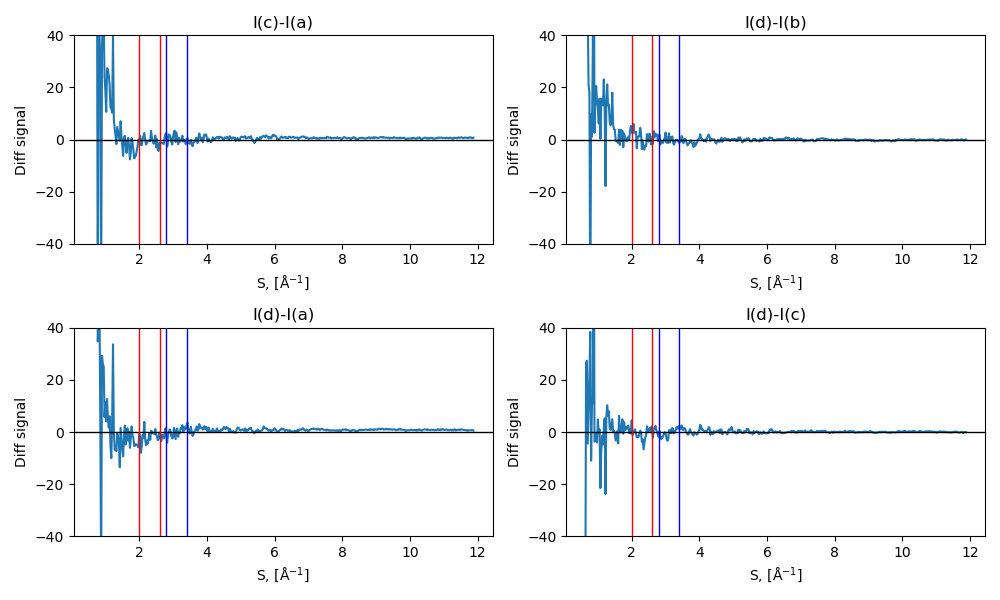

In [28]:
# (1) A B C D plot
s = np.arange(0,len(I_dlys[0]))*0.025 # The Q axis
realtime = -(uni_stage-posi_0)/0.15  # Delay axis in ps
ROI1 = [2.0,2.6]; # in Angstrom 
ROI2 = [2.8,3.4]; # in Angstrom

plt.figure(figsize=(10,6)) # Fig plot the different analysis

plt.subplot(2,2,1)
plt.plot(s,(I_dlys_Norm[1]-I_dlys_Norm[3])/I_dlys_Norm[3]**0);
plt.axhline(y = 0, color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');plt.ylabel('Diff signal');plt.title('I(c)-I(a)');
plt.ylim([-40, 40]);

plt.subplot(2,2,2)
plt.plot(s,(I_dlys_Norm[0]-I_dlys_Norm[2])/I_dlys_Norm[2]**0);
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel('Diff signal')
plt.title('I(d)-I(b)');
plt.axhline(y = 0, color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.ylim([-40, 40]);

plt.subplot(2,2,3)
plt.plot(s,(I_dlys_Norm[2]-I_dlys_Norm[3])/I_dlys_Norm[3]**0);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Diff signal');
plt.title('I(d)-I(a)');
plt.axhline(y = 0, color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.ylim([-40, 40]);

plt.subplot(2,2,4)
plt.plot(s,(I_dlys_Norm[0]-I_dlys_Norm[1])/I_dlys_Norm[1]**0);
plt.xlabel(r'S, ['+angs+'$^{-1}$]');
plt.ylabel('Diff signal');
plt.title('I(d)-I(c)');
plt.axhline(y = 0, color = 'k', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1);
plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
plt.ylim([-40, 40]);

plt.tight_layout()
plt.show()

## Plotting Power Dependence

NameError: name 'foldertail' is not defined

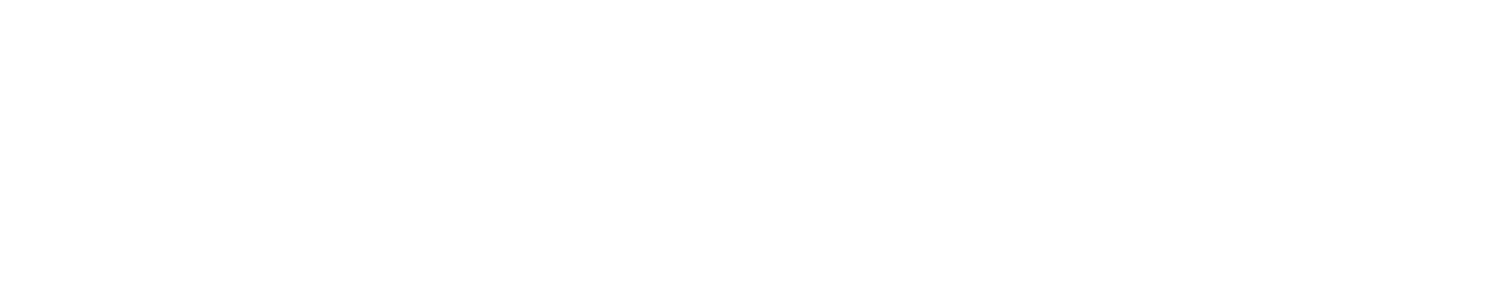

In [30]:
angs = '\u00C5';
realtime = -(uni_stage-posi_0)/0.15  # Delay axis in ps
plt_shift = 0.01;
DeltaI1_pws = [];
DeltaI2_pws = [];
Ratio_pws   = [];

plt.figure(figsize=(15,3)) # Fig plot the different analysis
for i_run, run in enumerate(foldertail):
    DeltaI1_pws.append(DeltaI1_pw[i_run][0:2].mean()-DeltaI1_pw[i_run][2:4].mean())
    DeltaI2_pws.append(DeltaI2_pw[i_run][0:2].mean()-DeltaI2_pw[i_run][2:4].mean())
    Ratio_pws.append(Ratio_pw[i_run][0:2].mean()-Ratio_pw[i_run][2:4].mean()*1);
    plt.subplot(1,len(foldertail),i_run+1)
    for i in range(nposi_pp):
        plt.plot(s,dI_I_dlys_Norm_pw[i_run][nposi_pp-i-1] + plt_shift*i);
        plt.axhline(y = plt_shift*i, color = 'k', linestyle = '-',linewidth=0.5);
        if i_run == len(foldertail)-1:
            plt.text(s[-1]+1,plt_shift*(i)/1, r'τ={0:.2f}ps'.format(realtime[nposi_pp-i-1]))
            
    plt.axvline(x = ROI1[0], color = 'r', linestyle = '-',linewidth=1);
    plt.axvline(x = ROI1[1], color = 'r', linestyle = '-',linewidth=1);
    plt.axvline(x = ROI2[0], color = 'b', linestyle = '-',linewidth=1)
    plt.axvline(x = ROI2[1], color = 'b', linestyle = '-',linewidth=1);
    plt.xlabel(r'S, ['+angs+'$^{-1}$]');
    plt.ylabel('ΔI/I');
    plt.title(r'4pt scan, ΔI/I, ' + str(Power[i_run]) + 'uJ');
    plt.ylim([np.nanmin(dI_I_dlys_Norm_pw[len(foldertail)-1][1]), np.nanmax(dI_I_dlys_Norm_pw[len(foldertail)-1][1] + plt_shift*i)])

plt.tight_layout()
plt.show()

plt.figure(figsize=(9,3)) # Fig plot the different analysis
plt.subplot(1,3,1)
plt.plot(Power,np.abs(DeltaI1_pws),'--d');
plt.xlabel('Power [uJ]');plt.ylabel('ΔI/I');plt.title('power scans, RoI1');

plt.subplot(1,3,2)
plt.plot(Power,np.abs(DeltaI2_pws),'--d');
plt.xlabel('Power [uJ]');plt.ylabel('ΔI/I');plt.title('power scans, RoI2');

plt.subplot(1,3,3)
plt.plot(Power,np.abs(Ratio_pws),'--d');
plt.xlabel('Power [uJ]');plt.ylabel('Ratio');plt.title('power scans, Ratio(RoI1-RoI2)');

plt.tight_layout()
plt.show()

# Simulated Data

## Functions

### SLAC Method 

In [ ]:
path_dcs='/sdf/data/lcls/ds/ued_testfac/scratch/gued_online_analysis/jupyter_notebook/user_notebooks/dcs_repository/3.7MeV/'
table=pd.read_csv(path_dcs+'Periodic_Table.csv')
def import_s():
    qe=1.602176565e-19 
    me=9.10938291e-31
    c=299792458 
    h=6.62606957e-34
    E=3700000*qe+me*c**2 #kinetic energy=3.7MeV
    p=(E**2/c**2-me**2*c**2)**0.5
    lamb=h/p
    k=2*np.pi/lamb #wave vector of the incident electron

    path=path_dcs+'C.dat'
    with open(path,'r') as file:
        a=file.read()
    a0=a.split('\n')
    theta_deg=np.empty(130)
    for i in range(130):
        a31=str(a0[31+i]).split(' ')
        theta_deg[i]=a31[2]
    
    theta=theta_deg*np.pi/180
    S=2*k*np.sin(0.5*theta)
    s=np.array(S)
    return s

def read_dat_dcs(atom_no,path_dcs):
    atom_sym=no_to_sym(atom_no)
    path=path_dcs+atom_sym+'.dat'
    with open(path,'r') as file:
        a=file.read()
    a0=a.split('\n')
    data=np.empty(130)
    for i in range(130):
        a31=str(a0[31+i]).split(' ')
        data[i]=a31[6]
    return data**0.5*1e8

def sym_to_no(ele_sym):
    n=np.where(table['Symbol']==ele_sym)
    return int(n[0]+1)

def no_to_sym(ele_no):
    return table['Symbol'][ele_no-1]

def import_DCS(max_at_no):
    f=np.empty((max_at_no+1,130))
    for i in range(max_at_no):
        f[i+1]=read_dat_dcs(i+1,path_dcs)
    return f

### Lauren's Method

In [73]:
 def read_xyz(filename):
    xyz_file = filename
    file = open(xyz_file, 'r')
    text = file.readlines()
    file.close()
    x = []
    y = []
    z = []
    atoms = []
    count = len(text)

    for j in range(0, count):
        try:
            string = list(map(str, text[j].split()))
            atoms.append(string[0])
            x.append(float(string[1]))
            y.append(float(string[2]))
            z.append(float(string[3]))
        except Exception:
            pass
    return atoms, x, y, z

def unique(atoms):
    unique_atoms = []
    for i in range(len(atoms)):
        if atoms[i] not in unique_atoms:
            unique_atoms.append(atoms[i])
    print(unique_atoms)
    return unique_atoms

def atom_index(atoms, unique_atoms):
    idx_all = []
    for i in range(len(atoms)):
        for j in range(len(unique_atoms)):
            if atoms[i] == unique_atoms[j]:
                idx_all.append(j)
    print(idx_all)
    return idx_all

def scat_phas(unique_atoms, Energy):
    Scatamps = []
    phas = []
    for atom in unique_atoms:
        df = pd.read_excel(form_factor_all, atom)
        string = atom + "_ff"
        data = df.to_csv(string, header=None)
        f = open(string,'r')
        ff_lines = f.readlines()[1:]
        f.close()
        s0 = []
        Scat = []
        eta = []
        for i in range(len(ff_lines)):
            string = list(map(str, ff_lines[i].split(",")))
            s0.append(float(string[1]))
            if Energy == 10000: 
                Scat.append(float(string[2]))
                eta.append(float(string[3]))
            elif Energy == 40000:
                Scat.append(float(string[4]))
                eta.append(float(string[5]))
            elif Energy == 60000:
                Scat.append(float(string[6]))
                eta.append(float(string[7]))
            elif Energy == 90000:
                Scat.append(float(string[8]))
                eta.append(float(string[9]))
            else:
                print("not a valid energy")
                break
        Scatamps.append(Scat)
        phas.append(eta)
    for atom in unique_atoms:
        string = atom + "_ff"
        os.remove(string)
    return s0, Scatamps, phas

def get_I_atomic(n, ds, s0, amps, phase, atoms, idx_all):
    I_at_all = []
    for i in range(len(atoms)):
        I_atomic = []
        I_at = 0
        interp_amps = interp.interp1d(s0, amps[idx_all[i]])
        interp_phase = interp.interp1d(s0, phase[idx_all[i]])
        stop = n/2 * ds
        s_new = np.arange(0, stop, ds)
        amps_new = interp_amps(s_new)
        phase_new = interp_phase(s_new)
        for k in range(len(amps_new)):
            f = amps_new[k]
            I_at = np.abs(f)**2
            I_atomic.append(float(I_at))
        I_at_all.append(I_atomic)
    return I_at_all, s_new

def get_I_molecular(atoms, x, y, z, n, ds, s0, amps, phase, idx_all):
    I_mol_all = []
    for i in range(0, len(atoms)):
        for j in range(0, len(atoms)): # Does each atom pair calculation twice
            I_mol = []
            if i == j:
                pass
            else:
                r_ij = (x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2 + (z[i] - z[j]) ** 2
                r_ij = r_ij ** 0.5
                interp_amps_i = interp.interp1d(s0, amps[idx_all[i]])
                interp_phase_i = interp.interp1d(s0, phase[idx_all[i]])
                interp_amps_j = interp.interp1d(s0, amps[idx_all[j]])
                interp_phase_j = interp.interp1d(s0, phase[idx_all[j]])
                stop = n/2 * ds
                s_new = np.arange(0, stop, ds)
                amps_new_i = interp_amps_i(s_new)
                phase_new_i = interp_phase_i(s_new)
                amps_new_j = interp_amps_j(s_new)
                phase_new_j = interp_phase_j(s_new)
                for k in range(len(amps_new_i)):
                    I_m = (amps_new_i[k])*np.conjugate(amps_new_j[k])*(np.sin(s_new[k]*r_ij)/(s_new[k]*r_ij))
                    I_mol.append(I_m)
            #print(len(I_mol))
            I_mol_all.append(I_mol)
    return I_mol_all

## Generate Static Scattering Signal -- Lauren's Version

### Get form factors

In [38]:
ff_path = "C:/Users/laure/OneDrive - University of Nebraska-Lincoln/Documents/Centurion Lab/matlab simulations/form factors.xlsx"
form_factor_all = pd.ExcelFile(ff_path)

In [39]:
xyzpath = "C:/Users/laure/OneDrive - University of Nebraska-Lincoln/Documents/Centurion Lab/matlab simulations/"
filename = xyzpath + "ntph_ground.xyz"
atoms, x, y, z = read_xyz(filename)
print(atoms)
print(len(atoms))

unique_atoms = unique(atoms)
idx_all = atom_index(atoms, unique_atoms)

s0, amps, phase = scat_phas(unique_atoms, 90000)

['C', 'C', 'C', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'N', 'O', 'O', 'O', 'H']
15
['C', 'H', 'N', 'O']
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 3, 3, 3, 1]


### Calculate I atomic

In [77]:
n = 2000 # number of pixels
ds = 0.0238 # pixel size in inverse angstroms

I_atomic_all, s_new = get_I_atomic(n, ds, s0, amps, phase, atoms, idx_all)
print(len(s_new))

1000


C:\Users\laure\AppData\Local\Temp\ipykernel_3904\59753022.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


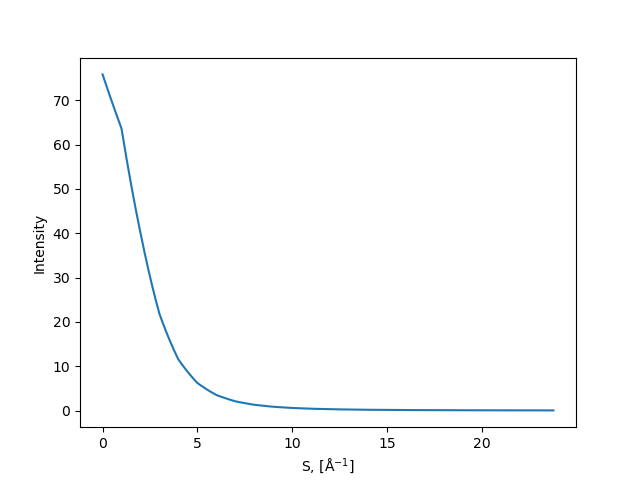

In [78]:
I_atomic_all = np.array(I_atomic_all)
#print(len(I_atomic_all))
I_atomic = sum(I_atomic_all)
#print(len(I_atomic))
#print(I_atomic)

angs = '\u00C5'

plt.figure()
plt.plot(s_new, I_atomic, label = "I atomic")
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel("Intensity")
plt.show()

### Calculate I molecular

In [79]:
U=90000; #Acceleration field in V
E=U*1.6022*1e-19;
m=9.1094e-31;
h=6.6261e-34;
c=299792458; #Physical constants
lam=h/np.sqrt(2*m*E)/np.sqrt(1+E/(2*m*c**2)); #Electron wavelength
k=2*np.pi/lam;

In [85]:
test = get_I_molecular(atoms, x, y, z, n, ds, s0, amps, phase, idx_all)
print(len(test))
test = [i for i in test if len(i) != 0]
print(len(test))
test_sum = sum(np.array(test))
print(len(test))

test_nonan = np.nan_to_num(test_sum)
print(len(test_nonan))
test_real = test_nonan.real
print(len(test_real))
I_mol = test_real
print(len(I_mol))

C:\Users\laure\AppData\Local\Temp\ipykernel_3904\1018650557.py:117: RuntimeWarning: invalid value encountered in double_scalars
  I_m = (amps_new_i[k])*np.conjugate(amps_new_j[k])*(np.sin(s_new[k]*r_ij)/(s_new[k]*r_ij))


225
210
210
1000
1000
998


In [81]:
I_tot = I_mol + I_atomic

<function matplotlib.pyplot.show(block=None)>

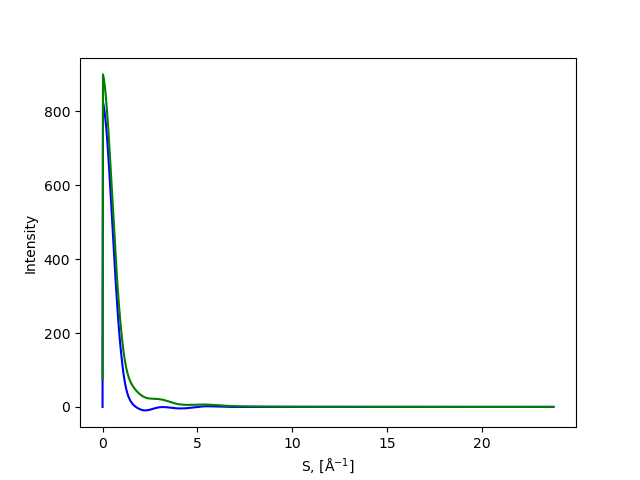

In [86]:
plt.figure()
plt.plot(s_new, I_mol, "b", label = "I molecular")
plt.plot(s_new, I_tot, "g", label="I total")
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel("Intensity")
plt.show

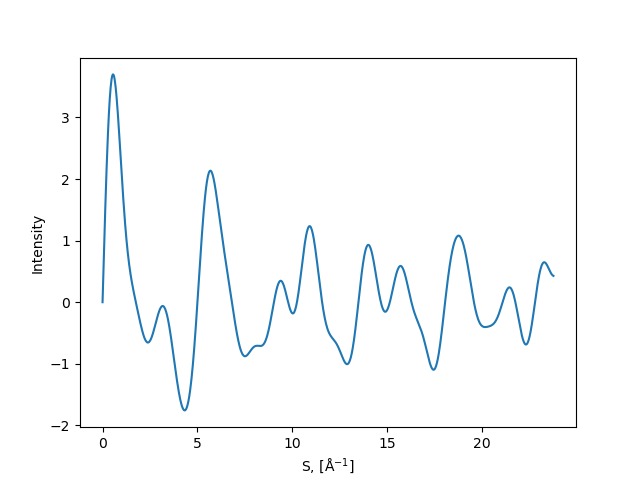

In [95]:
sm = s_new*(I_mol/I_atomic)

plt.figure()
plt.plot(s_new, sm)
plt.xlabel(r'S, ['+angs+'$^{-1}$]')
plt.ylabel("Intensity")
plt.show()

## Fitting Data to Theory

I want to be able to calibrate the s value by fitting the experimental data to the theory data. Can't figure out how though